# Introduction

## Problem Statement
Mobile app developers have come to prefer a subscription based monetization model for their apps. This provides them an incentive to continuously improve their apps and add new features. The predictable revenue in this monetization model also allows the business to handle their cashflow better. Customers, on the other hand, benefit from hassle-free recurring and automated payments. They don't have to worry about upgrading their software on a yearly basis as the apps are being updated continuously. Many major apps such as Spotify, Netflix, Calm, Evernote, and so on, use the subscription model to monetize their apps. 

To reduce the barrier of entry for potential subscribers, some apps offer free trials. This provides the customers a sneak peek of the product without a large cash committment upfront. One of these apps, whose usage data we will consider in this demo, provides a one week free trial to customers. The problem that we will try to solve is as follows:

> Predict whether a customer will continue with a paid subscription at the end of a one-week trial based on their usage data.

As this data has sequential information, we can guess that an RNN will perform well in this classification task. Let's now look at the data which we will use to train our RNN models.

## Data Description

Two files have been provided to you:
- _RNN\_data\_X.txt_: This file contains 8000 sequences which have lengths between 3 and 7. Let's take a look at the first few lines of this file in the image given below.

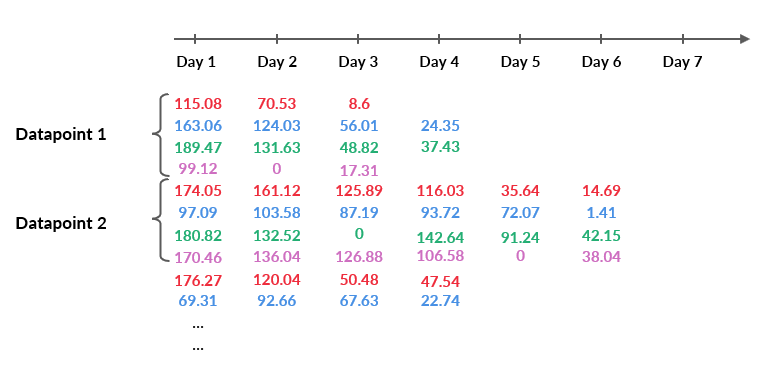

The file is made up of 8000 rows, each of which is a sequence of numbers. Each value is the number of minutes spent on a particular feature of the app per day. As the trial lasts a week, and we have data from users for a minimum of three days, the lengths of these sequences are numbers ranging from 3 to 7. You can also see that the first 4 lines put together represent the first data point, that is, the usage data of the first user. These 4 lines describe a user's usage data over 4 different features in the app. Therefore, in total, this file contains 8000/4 = 2000 data points.

- _RNN\_data\_y.txt_: This file contains the target variable values for the 2000 users. The target variable is binary (either a 1 or a 0), where 1 represents users who unsubscribe after the free trial and 0 represents the ones who continue.

You now have a preliminary understanding of the data. Next, we will setup our environment and prepare data for further analysis.

# Part 1 - Setup and Data Preparation
In this section, we will:
- Import necessary packages for executing the code
- Load the data
- Prepare the data for further analysis

Let's start by loading the required packages and data.

In [ ]:
# Import 'numpy' and 'pandas' for working with numbers and dataframes
import numpy as np
import pandas as pd

# Import 'pyplot' from 'matplotlib' and 'seaborn' for visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# Import 'pad_sequences' for data padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import 'train_test_split' for data partitioning
from sklearn.model_selection import train_test_split

# Import methods for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop

# Import 'GridSearchCV' for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Import 'KerasClassifier' from 'keras' for connecting neural networks with 'sklearn' and 'GridSearchCV'
from keras.wrappers.scikit_learn import KerasClassifier

# Import and execute method for suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the data files
X_data = []
with open('RNN_data_X.txt', 'r') as z:
    lines = z.readlines()
    for line in lines:
        X_data.append(list(map(float, line[:-1].split(', '))))

y_data = []
with open('RNN_data_y.txt', 'r') as z:
    lines = z.readlines()
    for line in lines:
        y_data.append(list(map(int, line[:-1]))[0])

In [ ]:
# Store the number of features in a variable 'n_features'
# Note: Each feature in the data corresponds to the time spent (in minutes per day) by users on a particular feature of the app
########## CODE HERE ##########

Now, let's explore the data. First let's check the class balance in _y\_data_.

In [ ]:
# Check the size of the data
print('Total number of data points:', len(y_data))
print('Total number of users who unsubcribe from the app:', y_data.count(1))
print('Total number of users who continue with their subscriptions:', y_data.count(0))

The class of interest or the class for which $y=1$ contains users who do not renew their subscription after the free trial. We will call them the _unsubscribe_ class. The users who take the subscription after the free trial will be called the _continue_ class. You can see that both classes 1 and 0 have the same number of records, hence we can say that the data set is perfectly balanced.

Let's now take a look at a few data points from the two different classes, along with the maximum and minimum sequence lengths in those data points.

In [ ]:
# Take a look at the data
sample_indices = [0, 4, 4000, 4004]
for index in sample_indices:
    if (index < (len(X_data) / 2)):
        data_point_type = 'Unsubscribe'
    else:
        data_point_type = 'Continue'
    print('{} sample: {}'.format(data_point_type, X_data[index:(index + n_features)]))
    print('Corresponding label: {}'.format(y_data[int(index / n_features)]))
    print('Minimum sequence length = {}'.format(min(len(sublist) for sublist in X_data[index:(index + n_features)])))
    print('Maximum sequence length = {}'.format(max(len(sublist) for sublist in X_data[index:(index + n_features)])))
    if index != sample_indices[len(sample_indices) - 1]:
        print('\n')

You can see that these data points have varying sequence lengths (ranging from 3 to 7). Missing data might be due to system data recording errors, server issues, etc. We cannot assume that a missing data point is associated with a user not using the app. 

To handle sequences of varying lengths, we usually pad the data with an arbitrary value that is not a part of the data set. A popular technique is to pad them with zeros. But we cannot do that if the data set contains meaningful zeros.

In [ ]:
# Select a padding value
# Note: We check whether the data has zeros since zero-padding is a common procedure
# Note: We also study the range of the data to select a suitable padding value
zeros = 0
for i in np.arange(0, len(X_data), 1):
    for j in X_data[i]:
        if j == 0:
            zeros = zeros + 1
print('The data has {} zeros'.format(zeros))
print('The maximum data value in the data is {}'.format(max(max(X_data, key = max))))
print('The minimum data value in the data is {}'.format(min(min(X_data, key = min))))

We can see that the data set contains 2115 zeros. A zero in the data means that a user has not spent any time on that specific feature of the app on that particular day. This is important information, so we cannot use zeros for padding.

The _Masking()_ layer, which is often used along with RNNs, allows you to effectively ignore the values which are being used to pad the data. But FCFNNs do not allow for its usage. So, to avoid skewing the results of the FCFNN, we use a masking value that is close to the actual input values. In this case, as 0 is the smallest value in the data set, we can use the value -1 to pad sequences. Using a large number like 999, may affect the training of the FCFNN and result in lower accuracy.

Let's now pad our sequences with -1s.

In [ ]:
# Pad 'X_data' with -1s
# Note: The 'pad_sequences()' method also converts lists into arrays which makes the data ready to be fed into neural networks
X_data_padded = ########## CODE HERE ##########

In [ ]:
# Take a look at 'X_data_padded'
for index in sample_indices:
    if (index < (len(X_data) / 2)):
        data_point_type = 'unsubscribe'
    else:
        data_point_type = 'continue'
    print('Padded {} sample: \n {}'.format(data_point_type, X_data_padded[index:(index + n_features)]))
    if index != sample_indices[len(sample_indices) - 1]:
        print('\n')

Note that all input sequences are now of the same length (7) due to padding.

In [ ]:
# Scale 'X_data_padded'
# Note: The data can be scaled by an arbitrary constant to avoid data leakage
X_data_padded = ########## CODE HERE ##########

In [ ]:
# Take a look at 'X_data_padded'
for index in sample_indices:
    if (index < (len(X_data) / 2)):
        data_point_type = 'unsubscribe'
    else:
        data_point_type = 'continue'
    print('Padded {} sample: \n {}'.format(data_point_type, X_data_padded[index:(index + n_features)]))
    if index != sample_indices[len(sample_indices) - 1]:
        print('\n')

In [ ]:
# Convert 'y_data' to a numpy array
# Note: The 'pad_sequences' method has already converted 'X_data' to numpy arrays
y_data = ########## CODE HERE ##########

# Part 2 - FCFNN
In this section, we will:
- Configure the input data dimensions for FCFNNs
- Define a function that creates an FCFNN
- Tune the FCFNN for different hyperparameter values
- View the performance of the optimal model on the test data

## Subpart 1 - FCFNN Input Data Specifications

In [ ]:
# Take a look at 'X_data_padded'
print('Padded unsubscribe sample \n {}'.format(X_data_padded[(sample_indices[0]):(sample_indices[0] + n_features)]))
print('\n')
print('Padded continue sample \n {}'.format(X_data_padded[(sample_indices[2]):(sample_indices[2] + n_features)]))

In [ ]:
# Take a look at the shape of 'X_data_padded'
########## CODE HERE ##########

In _X\_data\_padded_, currently, one row represents one feature and four rows put together represent one data point. For the data to be fed into an FCFNN, we need to concatenate the four rows together such that one row contains all four features. The length of each row will be $4\times7=28$. This means, the data set should be of the shape $(2000, 28)$. We can do this using the _reshape()_ method.

In [ ]:
# Redefine the shape of input data so that it can be fed into FCFNNs
# Note: Number of features for FCFNN = Number of actual features in the data X Number of timesteps per feature
X_data_fcfnn = ########## CODE HERE ##########

In [ ]:
# Take a look at 'X_data_fcfnn'
print('Padded unsubscribe sample \n {}'.format(X_data_fcfnn[sample_indices[0]]))
print('\n')
print('Padded continue sample \n {}'.format(X_data_fcfnn[int(sample_indices[2] / n_features)]))

In [ ]:
# Take a look at the shape of 'X_data_fcfnn'
########## CODE HERE ##########

Let's now perform the train-test split.

In [ ]:
# Split 'X_data_fcfnn' and 'y_data' into training and testing sets
X_train, X_test, y_train, y_test = ########## CODE HERE ##########

The length of the inner list, 28, specifies the number of features expected by the input layer of our FCFNN. Let's save that in a tuple in a separate variable for future reference.

In [ ]:
# Store input data shape for FCFNNs
# Note: Keras expects the input dimensions in the form of a tuple
inputdims_fcfnn = ########## CODE HERE ##########
print('Input dimensions for FCFNN input layer: {}'.format(inputdims_fcfnn))

Let's now take a look at how this data is fed into the neural network during a forward operation.

In [ ]:
# Take a look at how input data is fed into a sample FCFNN
X_train[0]

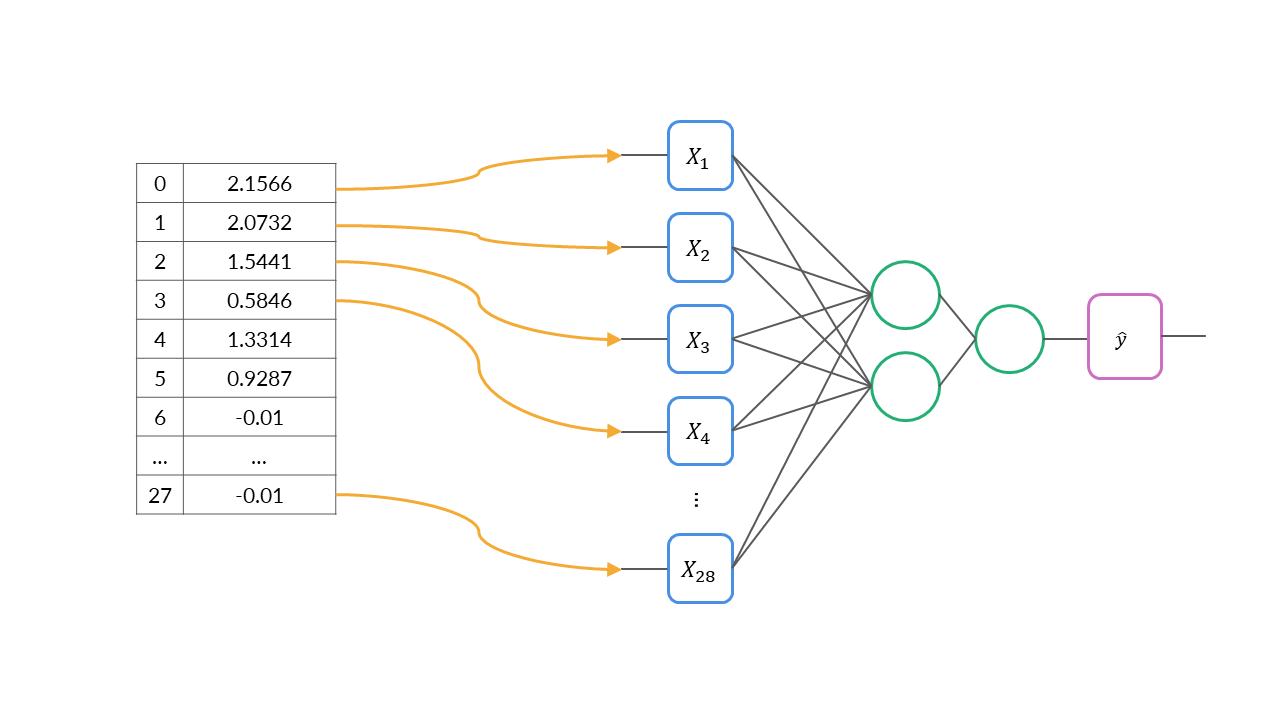

## Subpart 2 - FCFNN Function

We will now define a function to create an FCFNN. Let's take a look at its parameters:
- _neurons\_config_ allows you to input the configuration of neurons in the FCFNN as a list. The number of layers is given by length of the list. Each value in the list specifies the number of neurons in the corresponding layer.
- _activation\_function\_fcfnn_ allows you to specify an activation function for the hidden layers in your neural network.

The output of the function will be the compiled neural network.

In [ ]:
# Define a function to create an FCFNN model and specify default values for hyperparameters
def create_nn(neurons_config = [1],
              activation_function_fcfnn = 'sigmoid'):
    
    # Declare an instance of a neural network model
    nn = ########## CODE HERE ##########
    
    # Specify the input shape by adding an input layer
    nn.########## CODE HERE ##########
    
    # Interpret number of hidden layers
    n_fcfnn = ########## CODE HERE ##########
    
    # Conditionally add hidden layers to the network
    for i in np.arange(0, n_fcfnn, 1):
        nn.########## CODE HERE ##########
    
    # Add an output layer to the network
    # Note: Since this is a binary classification exercise, we use one output neuron with a sigmoid activation function
    nn.########## CODE HERE ##########
    
    # Compile the network
    # Note: Since this is a binary classification exercise, we use binary crossentropy as the loss function
    nn.########## CODE HERE ##########
    
    return(nn)

## Subpart 3 - FCFNN Models

Let's now perform a grid search over different configurations and activation functions.

In [ ]:
# Initialize a basic FCFNN object using the 'KerasClassifier()' method
base_grid_model = ########## CODE HERE ##########

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = ########## CODE HERE ##########

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = ########## CODE HERE ##########

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = ########## CODE HERE ##########

In [ ]:
# View the optimal values of the hyperparameters
best_neurons_config = grid_model.best_params_['neurons_config']
best_activation_function_fcfnn = grid_model.best_params_['activation_function_fcfnn']
best_accuracy = grid_model.best_score_

print('The optimal configuration of hidden layer neurons is', best_neurons_config)
print('The optimal activation function for non-output neurons is', best_activation_function_fcfnn)
print('The accuracy of the model with these optimal parameters is ', best_accuracy)

## Subpart 4 - Optimal FCFNN Model

Let's now train a potentially optimal FCFNN model.

In [ ]:
# Create an FCFNN model with a combination of potentially optimal hyperparameter values and retrain the model
nn1 = ########## CODE HERE ##########

nn1.summary()
print('\n')
nn1_history = ########## CODE HERE ##########

In [ ]:
# Convert the FCFNN history object into a data frame to view its specifics
hist = pd.DataFrame(nn1_history.history)
hist['epoch'] = nn1_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist.set_index('epoch')

In [ ]:
# View the training and validation accuracies as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'accuracy', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_accuracy', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the accuracy of the model on the testing data set
performance_test = ########## CODE HERE ##########

print('The loss value of the model on the test data is {}'.format(performance_test[0]))
print('The accuracy of the model on the test data is {}'.format(performance_test[1]))

Even though FCFNNs are not designed to extract sequential information out of data, this model performs reasonably well. But variable length sequences make it difficult to work with these models. It is also worth noting that the number of parameters in the FCFNN is directly proportional to the lengths of the sequences in the data.

In the next section, we will see how RNNs handle variable length sequences differently.

# Part 3 - RNN
In this section, we will:
- Configure the input data dimensions for RNNs
- Define a function that creates an RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

## Subpart 1 - RNN Input Data Specifications

In [ ]:
# Take a look at 'X_data_padded'
print('Padded unsubscribe sample \n {}'.format(X_data_padded[(sample_indices[0]):(sample_indices[0] + n_features)]))
print('\n')
print('Padded continue sample \n {}'.format(X_data_padded[(sample_indices[2]):(sample_indices[2] + n_features)]))

In [ ]:
# Take a look at the shape of 'X_data_padded'
########## CODE HERE ##########

Currently, each row in _X\_data\_padded_ represents a feature and contains 7 (padded) timesteps. The _SimpleRNN()_ layer expects the data to be of the form _(number of sample, length of sequences, number of features)_. For our data set, the expected shape will be $(2000, 7, 4)$. But _X\_data\_padded_ is of the shape $(8000,7)$. We can change the shape of the data set using a combination of the _reshape()_ and _transponse()_ methods. 

In [ ]:
# Redefine the shape of input data so that it can be fed into RNNs
# Note: The data should be reshaped to the form (number of samples, length of sequences, number of features)
X_data_rnn = ########## CODE HERE ##########

In [ ]:
# Take a look at 'X_data_rnn'
print('Padded unsubscribe sample \n {}'.format(X_data_rnn[sample_indices[0]]))
print('\n')
print('Padded continue sample \n {}'.format(X_data_rnn[int(sample_indices[2] / n_features)]))

In [ ]:
# Take a look at the shape of 'X_data_rnn'
########## CODE HERE ##########

In [ ]:
# Redefine the shape of input data so that it can be fed into RNNs
# Note: The data should be reshaped to the form (number of samples, length of sequences, number of features)
X_data_rnn = ########## CODE HERE ##########

In [ ]:
# Take a look at 'X_data_rnn'
print('Padded unsubscribe sample \n {}'.format(X_data_rnn[sample_indices[0]]))
print('\n')
print('Padded continue sample \n {}'.format(X_data_rnn[int(sample_indices[2] / n_features)]))

In [ ]:
# Take a look at the shape of 'X_data_rnn'
########## CODE HERE ##########

Note that the dimensions of the inputs are now of the form (*number of samples*, *number of time steps*, *number of features*).

Let's now perform the train-test split.

In [ ]:
# Split 'X_data_rnn' and 'y_data' into training and testing sets
X_train, X_test, y_train, y_test = ########## CODE HERE ##########

In [ ]:
# Take a look at how input data is fed into a sample RNN
X_train[0]

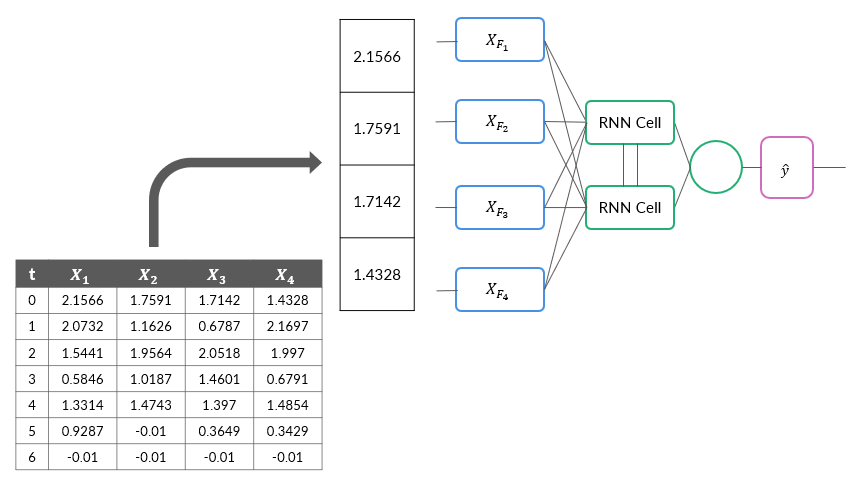

The input in our data will be of the shape $(7,4)$. We will now save this in a tuple in a separate variable for future reference.

In [ ]:
# Store input data shape for RNNs
# Note: Keras expects the input dimensions in the form of a tuple
inputdims_rnn = ########## CODE HERE ##########
print('Input dimensions for RNN input layer: {}'.format(inputdims_rnn))

## Subpart 2 - RNN Function


We will now define a function to create an RNN. Let's take a look at its parameters:
- _cells\_config_ allows you to input the configuration of RNN cells in the RNN as a list. The number of layers is given by length of the list. Each value in the list specifies the number of RNN cells in the corresponding layer.
- _activation\_function\_rnn_ allows you to specify an activation function for the hidden layers in your neural network.

The output of the function will be the compiled neural network.

Note that we are adding a masking layer before the _SimpleRNN()_ layer. The _Masking()_ layer is propagated to all recurrent layers, so we need only one masking layer.

In [ ]:
# Define a function to create an RNN model and specify default values for hyperparameters
def create_rnn(cells_config = [1],
               activation_function_rnn = 'sigmoid'):
    
    # Declare an instance of a neural network model
    nn = ########## CODE HERE ##########
    
    # Specify the input shape by adding an input layer
    nn.########## CODE HERE ##########
    
    # Interpret the number of recurrent layers
    n_rnn = ########## CODE HERE ##########
    
    # Add a masking layer
    # Note: Recall that the input sequences were padded with -1s (scaled down to -0.01s)
    nn.########## CODE HERE ##########
    
    # Conditionally add recurrent layers to the network
    # Note: All non-ultimate recurrent layers have 'return_sequences' set to 'True'
    for i in np.arange(0, n_rnn - 1, 1):
        nn.########## CODE HERE ##########
    
    # Add the ultimate recurrent layer
    # Note: The ultimate recurrent layer has 'return_sequences' set to 'False'
    nn.########## CODE HERE ##########
    
    # Add an output layer to the network
    # Note: Since this is a binary classification exercise, we use one output neuron with a sigmoid activation function
    nn.########## CODE HERE ##########
    
    # Compile the network
    # Note: Since this is a binary classification exercise, we use binary crossentropy as the loss function
    nn.########## CODE HERE ##########
    
    return(nn)

## Subpart 3 - RNN Models

Let's now perform a grid search with different cell configurations and activation functions.

In [ ]:
# Initialize a basic RNN object using the 'KerasClassifier()' method
base_grid_model = ########## CODE HERE ##########

# Define ranges of hyperparameters and store it in a parameter grid dictionary
parameters_grid = ########## CODE HERE ##########

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
grid = ########## CODE HERE ##########

# Fit the grid model to the training data
# Note: There is no need for validation split here as cross-validation is already in place
grid_model = ########## CODE HERE ##########

In [ ]:
# View the optimal values of the hyperparameters
best_cells_config = grid_model.best_params_['cells_config']
best_activation_function_rnn = grid_model.best_params_['activation_function_rnn']
best_accuracy = grid_model.best_score_

print('The optimal configuration of RNN cells is', best_cells_config)
print('The optimal activation function for recurrent neurons is', best_activation_function_rnn)
print('The accuracy of the model with these optimal parameters is ', best_accuracy)

## Subpart 4 - Optimal RNN Model

Let's now train a potentially optimal RNN model.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
nn2 = ########## CODE HERE ##########

nn2.summary()
print('\n')
nn2_history = ########## CODE HERE ##########

In [ ]:
# Convert the RNN history object into a data frame to view its specifics
hist = pd.DataFrame(nn2_history.history)
hist['epoch'] = nn2_history.epoch
hist['epoch'] = hist['epoch'].apply(lambda x: x + 1)
hist.set_index('epoch')

In [ ]:
# View the training and validation accuracies as functions of epoch
plt.figure(figsize = (14, 4))

sns.lineplot(data = hist, x = 'epoch', y = 'accuracy', color = 'red', label = 'Train')
sns.lineplot(data = hist, x = 'epoch', y = 'val_accuracy', color = 'blue', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy as a Function of Epoch');

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the accuracy of the model on the testing data set
performance_test = ########## CODE HERE ##########

print('The loss value of the model on the test data is {}'.format(performance_test[0]))
print('The accuracy of the model on the test data is {}'.format(performance_test[1]))

The RNN performs as well as, if not better than, the FCFNN with considerably less parameters. This is because RNNs are designed to model sequential patterns in data.

RNNs and FCFNNs can predict from input sequences of varying lengths if padding and masking procedures have been duly implemented, but the foreign value introduced by padding can influence the performance of FCFNNs. This doesn't affect RNNs because of the masking layer.

But simple RNNs can not handle longer sequences. This is because they are not designed to hold long term patterns in memory, and they also suffer from vanishing and exploding gradients. LSTM and GRU networks are more suitable for such data sets.